# Goal<br>
* Develop a machine learning model using bag of words and vectorization that will take in Netflix descriptions of shows in it's database and predict wether the show matching each discription belongs to a given genre<br>

* Inestigate wether this technique can be inhanced by identifying "unique words," words that only occur in discriptions belonging to that genre

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e
import model as m

#pd.set_option('display.max_colwidth', None)

# Wrangle

Data acquired from kaggle 
Each represints a show featured by Netflix

Columns not representing show descriptions or genres were dropped
A boolean column for each genre appearing in the "genres" column was added signifying if each show belonged to that genre

Rows containning blank descriptions were dropped
'Western' column was dropped do to low represintation (only 41 rows)

Data contains 5791 rows after being prepared 

Note:
    
* adding words two letters and fewer to those removed by stopwords, on next iteration investigate for useful words
* using raw counts for frequency measure, on next iteration consider using percentage

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")
print(f"Validate set contains {validate.shape[0]} rows of data")
print(f"Test set contains {test.shape[0]} rows of data")

Train set contains 3242 rows of data
Validate set contains 1390 rows of data
Test set contains 1159 rows of data


# Explore

In [3]:
# get set of non-western genres
gen_set = e.get_gens(train)

# get relative word frequency list and list of only the numbers
word_freq = e.get_word_freq(train)
word_counts = e.get_counts(word_freq)

# get relative document frequency list and list of only the numbers
doc_freq = e.get_doc_freq(train)
doc_counts = e.get_counts(doc_freq)

**1) Investigate data and choose a genre as a test case**

   * Test case should have a large represintation in the data
   * Test case should have a large number of unique words
   * Test case should have a large number of unique words per document

**How many shows are there of each genre?**

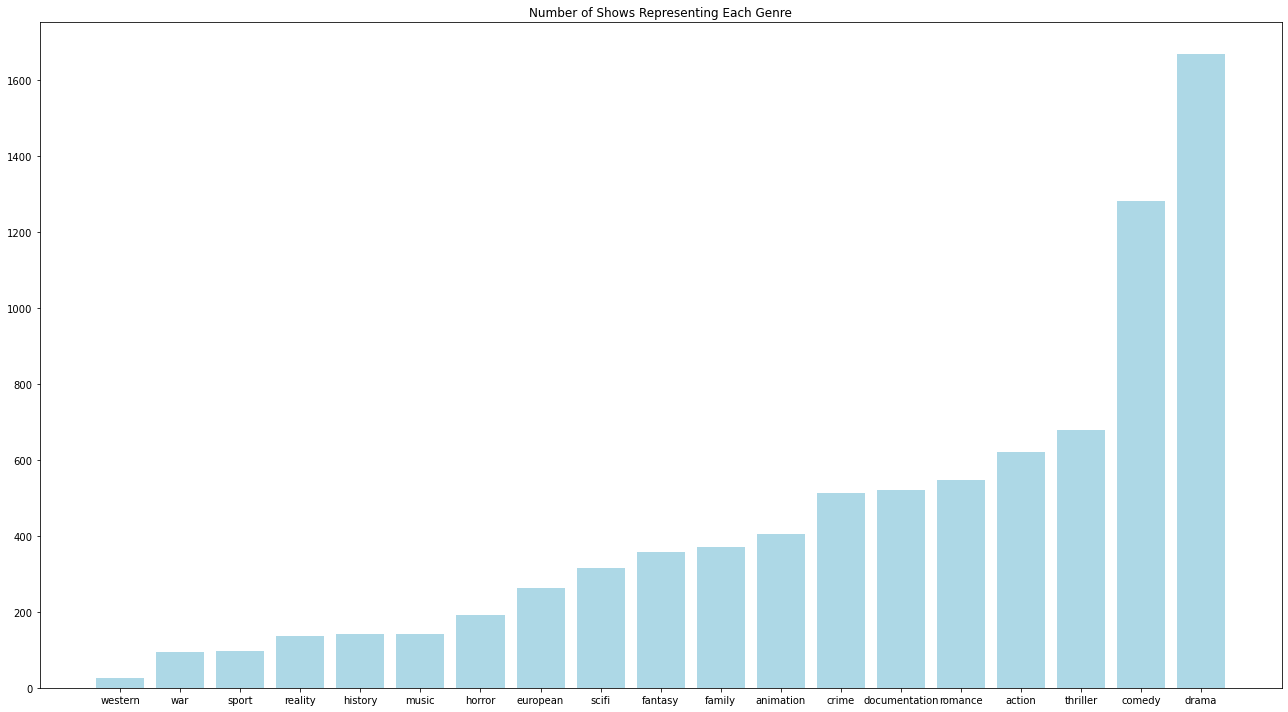

In [4]:
# get distribution of genres
e.shows_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners.

**How many words in each genre are unique words? (Appear only in descriptions of movies of that fall under that genre)**

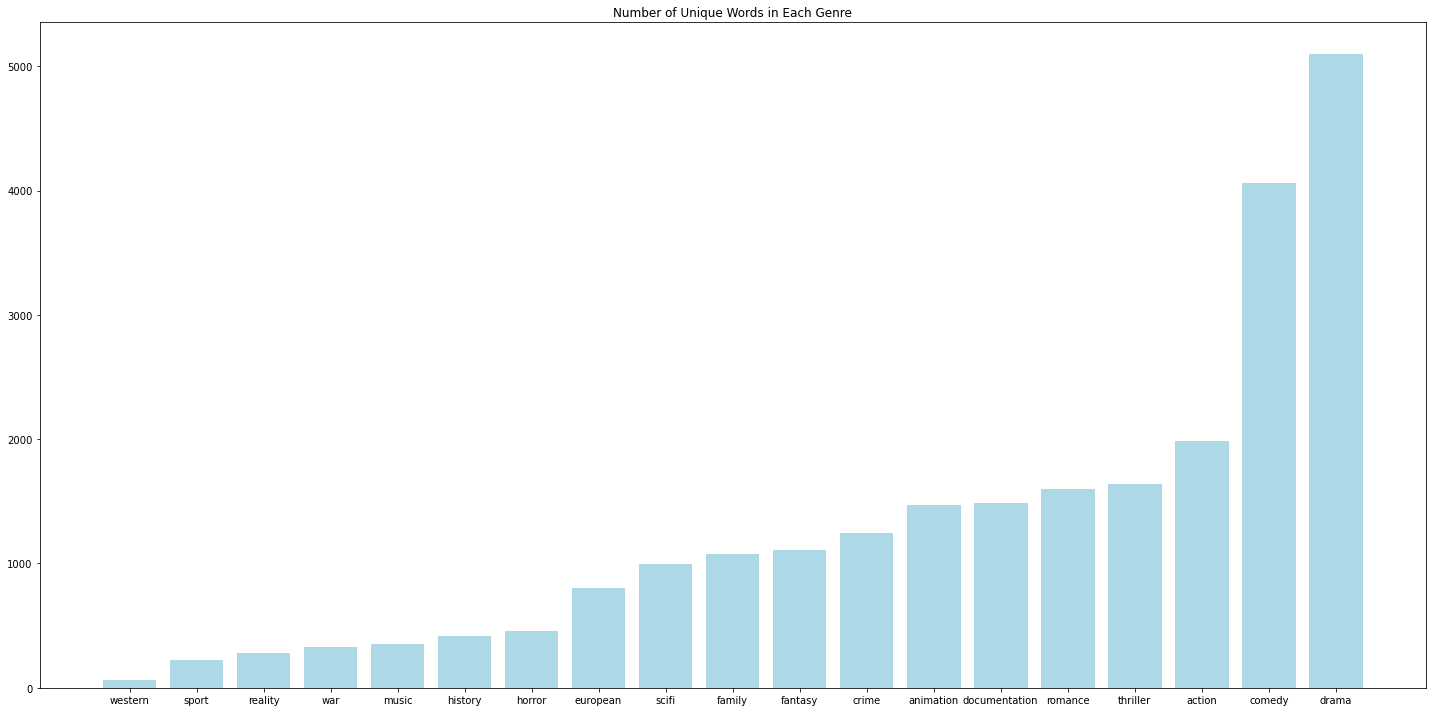

In [5]:
# get number of unique words fro each genre
e.unique_words_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners for unique words as well.

**How fequently do unique words appear in each genre?**

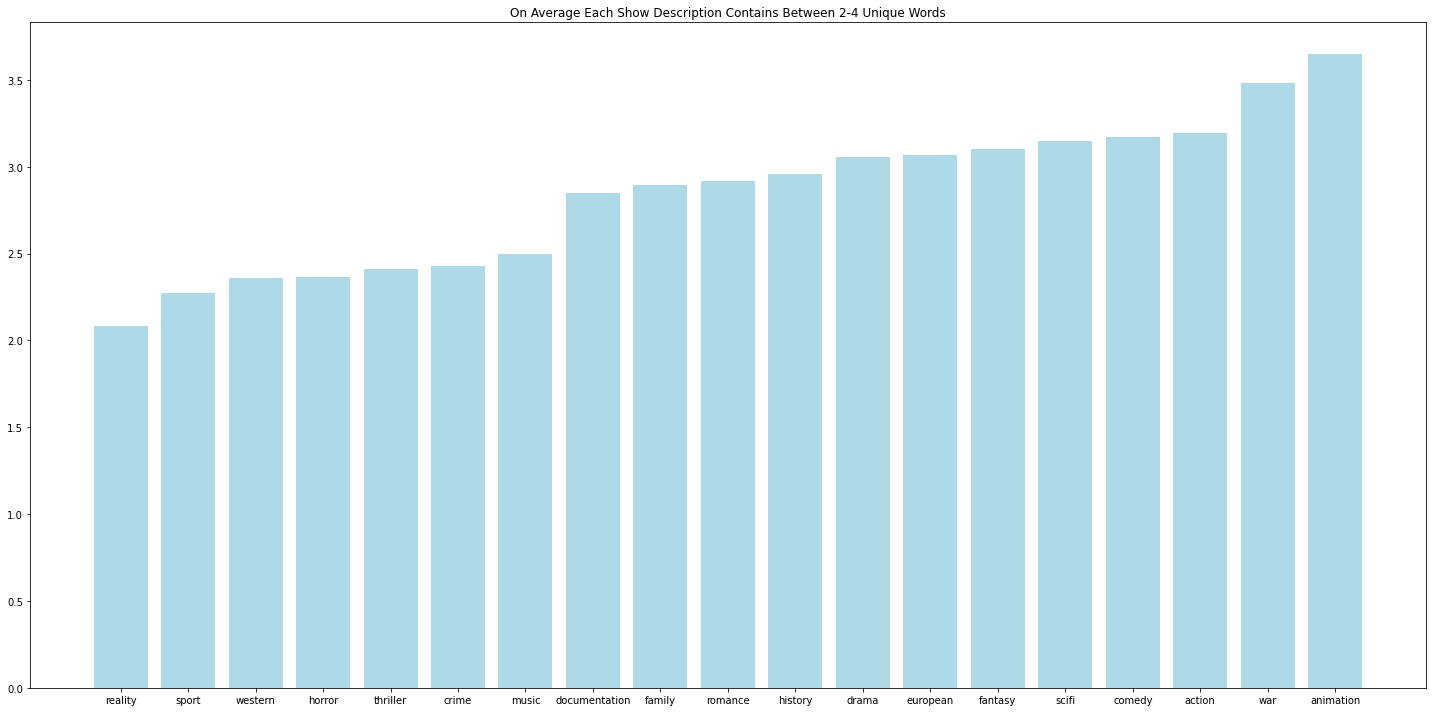

In [6]:
# get frequency of unique words pre genre
e.unique_words_frequency(train, gen_set)

Not a great deal of variance in unique word frequency. Comedy and Drama both have grater than three they were front runners in the other two criteria

**Comedy** and **Drama** have consistantly high values in all test criteria.
Comedy seems the less vague of the two genres, by human understanding. I will choose **Comedy** as my test case.

**2) Investigate test case (Comedy) and see how it compares to the rest of the data**

* What percent of the data is classified as a Comedy?
* Are there any words that appear more or less frequently across comedy or non-comedy show descriptions? <br>(Overall/by document)

**How much of the data is Comedy?**

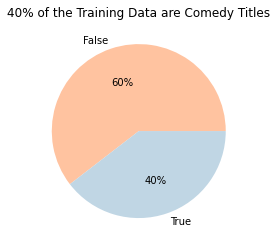

In [7]:
e.omni_pie(train.comedy, "40% of the Training Data are Comedy Titles")

**Can we use the relative frequency of words in descriptions to seperate noise from signal?**

**The following chart shows a histogram of the relative document frequency of each unique word appearing in film descriptions**
<br>
The number is calculated in the following way: <br>
number of comedy documents the word appears in minus the number of non-comedy documents the word appears in

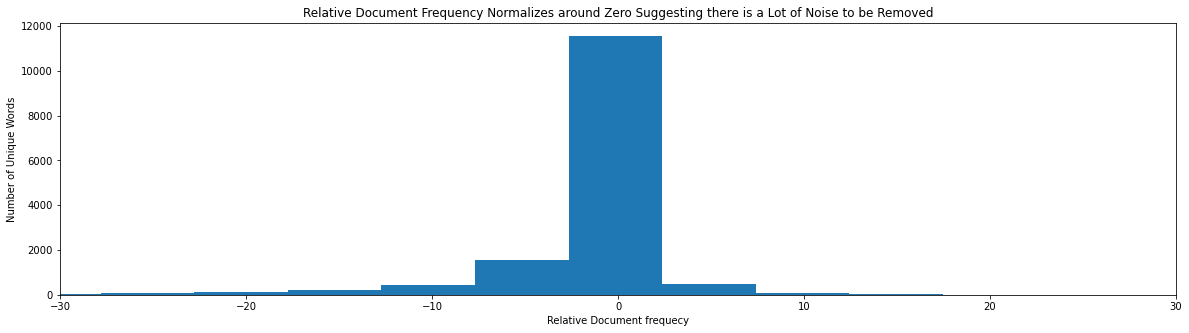

In [8]:
e.get_hist_doc(doc_counts)

* Data appears to normalize around 0 however the steps are steeper on the positive side
* Skew is likely do to the 60/40 imbalance in the data

**The following chart shows the relative frequency of each unique word appearing film descriptions**
The number is calculated in the following way: <br>
number of times the word appears in comedy documents minus number of times the word appears in non-comedy documents

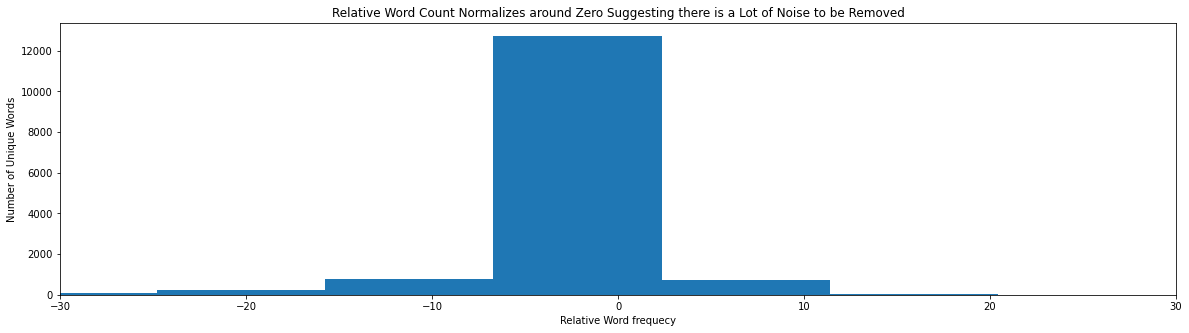

In [9]:
e.get_hist_word(word_counts)

* Data appears to normalize around -2 and there seems to be more negative values than positive ones
* Skew is likely do to the 60/40 imbalance in the data

Words that do not have a significant difference in apearances between comedy and non-comedy films will not be useful in guiding the model. Looking at the results of these distributions tells me that once the data is vectorized there will be a lot of noise words that can be dropped to make sure that signal words are having a stronger impact on the model.

**As a quick sanity test lets take a look at our top 15 most extream values for document and word frequency**

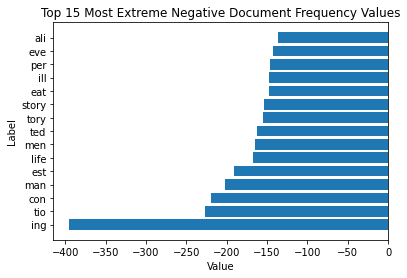

In [10]:
e.get_doc_ext(dict(doc_freq[:15]), "Top 15 Most Extreme Negative Document Frequency Values")

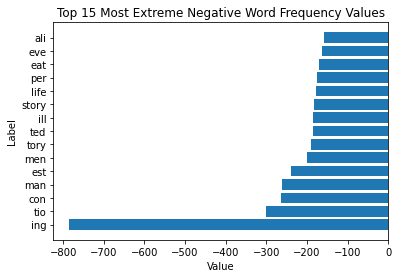

In [11]:
e.get_doc_ext(dict(word_freq[:15]), "Top 15 Most Extreme Negative Word Frequency Values")

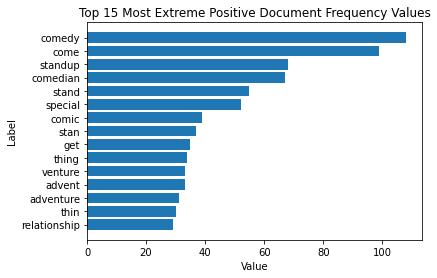

In [12]:
e.get_doc_ext(dict(doc_freq[-15:]), "Top 15 Most Extreme Positive Document Frequency Values")

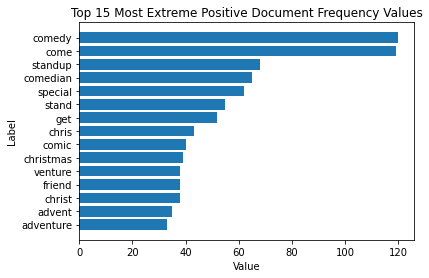

In [13]:
e.get_doc_ext(dict(word_freq[-15:]), "Top 15 Most Extreme Positive Document Frequency Values")

* Extreme negative values seem suspect due to the imbalance in the data words commen to both comedy and non-comedy films may have a large negative value because there are more non-comedy films in the data.
* Extreme positive value words are intuatively indicitive of the comedy genre and servive in spite of the data imbalance working against them. They seem like good indicators.

# Modeling

I will be examining different tequniques for building the most accurate possible model. Techniques include using word count vs TF-IDF, differint machine learning classification models, and a number of feature engineering ideas. For this reason models will be graded on overall accuracy above all. Ties will be decided by fewist false negatives. As a buisness case, it seems better to me to present a movie to a customer out of genre then to fail to present an in ingenre film that might increase that customers watchtime, provided these occurances are kept to a minimum.
Because the data has a 60/40 split my beginning baseline is 60% and will hopefully be improved on throughout the modeling process.

In [14]:
# seperate train, validate and test data into X (description) and y (comedy) 
train_X = train[['description']].reset_index(drop=True)
train_y = train[['comedy']].reset_index(drop=True)

validate_X = validate[['description']].reset_index(drop=True)
validate_y = validate[['comedy']].reset_index(drop=True)

test_X = test[['description']].reset_index(drop=True)
test_y = test[['comedy']].reset_index(drop=True)

## Count Analysis - Full Vectorization Array

In [15]:
train_counts, validate_counts, test_counts = m.get_vector_counts(train_X, validate_X, test_X)

In [16]:
m.get_acc_table(train_counts, train_y, validate_counts, validate_y)

Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 64.82%
Random Forest  Train: 99.97% Validate: 69.86%
K Neighbors  Train: 62.86000000000001% Validate: 60.5%
Logistic Regression Train: 99.78% Validate: 71.8%


When predicting on raw counts the logistic regression and random forest models both broke 70% accuracy. Lets see if I can improve on that by cutting out some of the noise. For the next two attempts I will drop all of the words that with a 0 relative frequency for document and raw count frequency. 

## Count Analysis - Drop low Relative Frequency - Raw Counts

In [17]:
def remove_low_freq(df, freq_dict, threshold):
    ''' removes columns from df if abs val of relative freq is equal or less than input number '''
    
    for col in df.columns.to_list():
        
        if abs(freq_dict[col]) <= threshold:
            
            df = df.drop(columns=[col])
    
    return df

In [18]:
def get_acc_after_freq_drop(train_X, train_y, validate_X, validate_y, freq_lst, threshold):
    ''' get accuracy table after dropping words from training data 
        that have a relative freq less than the input number'''
    
    
    train_X = remove_low_freq(train_X, dict(freq_lst), threshold)
    validate_X = remove_low_freq(validate_X, dict(freq_lst), threshold)

    print(f"Drop threshold is {threshold}")
    m.get_acc_table(train_X, train_y, validate_X, validate_y)

In [19]:
for item in [0,5,20,50,100]:
    
    get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, word_freq, item)

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 65.97%
Random Forest  Train: 99.97% Validate: 70.07%
K Neighbors  Train: 63.13999999999999% Validate: 60.22%
Logistic Regression Train: 99.6% Validate: 71.94%
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 99.94% Validate: 63.88%
Random Forest  Train: 99.94% Validate: 70.22%
K Neighbors  Train: 80.35% Validate: 58.63%
Logistic Regression Train: 88.99000000000001% Validate: 69.28%
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 98.11999999999999% Validate: 61.8%
Random Forest  Train: 98.11999999999999% Validate: 65.18%
K Neighbors  Train: 75.44999999999999% Validate: 60.5%
Logistic Regression Train: 75.72% Validate: 69.64%
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 80.97% Validate: 63.239999999999995%
Random Forest  Train: 80.97% Validate: 64.46%
K Neighbors  Train: 70.82000000000001% Validate: 62.519999999999996

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 65.97%
Random Forest  Train: 99.97% Validate: 70.07%
K Neighbors  Train: 63.13999999999999% Validate: 60.22%
Logistic Regression Train: 99.6% Validate: 71.94%
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 99.94% Validate: 63.88%
Random Forest  Train: 99.94% Validate: 70.22%
K Neighbors  Train: 80.35% Validate: 58.63%
Logistic Regression Train: 88.99000000000001% Validate: 69.28%
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 98.11999999999999% Validate: 61.8%
Random Forest  Train: 98.11999999999999% Validate: 65.18%
K Neighbors  Train: 75.44999999999999% Validate: 60.5%
Logistic Regression Train: 75.72% Validate: 69.64%
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 80.97% Validate: 63.239999999999995%
Random Forest  Train: 80.97% Validate: 64.46%
K Neighbors  Train: 70.82000000000001% Validate: 62.519999999999996%
Logistic Regression Train: 68.72% Validate: 66.03999999999999%
Drop threshold is 100
Accuracy Scores
---------------
Decision Tree  Train: 67.4% Validate: 62.519999999999996%
Random Forest  Train: 67.4% Validate: 62.59%
K Neighbors  Train: 63.629999999999995% Validate: 58.35%
Logistic Regression Train: 64.1% Validate: 63.31%







Accuracy Scores for Nothing Dropped
---------------
Decision Tree  Train: 0.999691548426897 Validate: 0.6482014388489209 <br>
Random Forest  Train: 0.999691548426897 Validate: 0.6985611510791367 <br>
KNeighbors  Train: 0.6286243059839605 Validate: 0.6050359712230216 <br>
Logistic  Train: 0.9978408389882788 Validate: 0.7179856115107913 <br>

Accuracy Scores for Drop Threshold 0
---------------
Decision Tree  Train: 0.999691548426897 Validate: 0.6597122302158274 <br>
Random Forest  Train: 0.999691548426897 Validate: 0.7007194244604317 <br>
   KNeighbors  Train: 0.6314003701418878 Validate: 0.602158273381295 <br>
     Logistic  Train: 0.9959901295496607 Validate: 0.7194244604316546 <br>

Accuracy Scores for Drop Threshold 5
---------------
Decision Tree  Train: 0.999383096853794 Validate: 0.6388489208633094 <br>
Random Forest  Train: 0.999383096853794 Validate: 0.702158273381295 <br>
KNeighbors  Train: 0.8035163479333745 Validate: 0.5863309352517986 <br>
Logistic  Train: 0.8898827884022209 Validate: 0.6928057553956835 <br>

Accuracy Scores for Drop Threshold 20
---------------
Decision Tree  Train: 0.9811844540407156 Validate: 0.6179856115107913 <br>
Random Forest  Train: 0.9811844540407156 Validate: 0.6517985611510791 <br>
KNeighbors  Train: 0.7544725478099938 Validate: 0.6050359712230216 <br>
Logistic  Train: 0.757248611967921 Validate: 0.6964028776978417 <br>

Accuracy Scores for Drop Threshold 50
---------------
Decision Tree  Train: 0.809685379395435 Validate: 0.6323741007194245 <br>
Random Forest  Train: 0.809685379395435 Validate: 0.6446043165467625 <br>
KNeighbors  Train: 0.7082048118445404 Validate: 0.625179856115108 <br>
Logistic  Train: 0.6872301048735349 Validate: 0.660431654676259 <br>

Accuracy Scores for Drop Threshold 100
---------------
Decision Tree  Train: 0.6739666872301049 Validate: 0.625179856115108 <br>
Random Forest  Train: 0.6739666872301049 Validate: 0.6258992805755396 <br>
KNeighbors  Train: 0.636335595311536 Validate: 0.5834532374100719 <br>
Logistic  Train: 0.6409623689080814 Validate: 0.6330935251798561 <br>

## Count Analysis - Drop low Relative Frequency - Document Counts

In [20]:
for item in [0,5,20,50,100]:

    get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, doc_freq, item)

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 65.9%
Random Forest  Train: 99.97% Validate: 70.22%
K Neighbors  Train: 63.39% Validate: 60.36%
Logistic Regression Train: 99.53999999999999% Validate: 71.37%


KeyboardInterrupt: 

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 0.999691548426897 Validate: 0.6589928057553956
Random Forest  Train: 0.999691548426897 Validate: 0.702158273381295
KNeighbors  Train: 0.6338679827267119 Validate: 0.6035971223021582
Logistic  Train: 0.9953732264034546 Validate: 0.7136690647482015
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 0.999383096853794 Validate: 0.6345323741007194
Random Forest  Train: 0.999383096853794 Validate: 0.6956834532374101
KNeighbors  Train: 0.8099938309685379 Validate: 0.5690647482014388
Logistic  Train: 0.8778531770512029 Validate: 0.7028776978417266
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 0.9790252930289944 Validate: 0.5992805755395684
Random Forest  Train: 0.9790252930289944 Validate: 0.6517985611510791
KNeighbors  Train: 0.7594077729796422 Validate: 0.5913669064748202
Logistic  Train: 0.7461443553362123 Validate: 0.685611510791367
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 0.7763726095003084 Validate: 0.637410071942446
Random Forest  Train: 0.7763726095003084 Validate: 0.6474820143884892
KNeighbors  Train: 0.6730413325107958 Validate: 0.5798561151079137
Logistic  Train: 0.6798272671190623 Validate: 0.6661870503597123
Drop threshold is 100
Accuracy Scores
---------------
Decision Tree  Train: 0.6637877853177051 Validate: 0.6273381294964029
Random Forest  Train: 0.6637877853177051 Validate: 0.625179856115108
KNeighbors  Train: 0.6017890191239975 Validate: 0.5654676258992806
Logistic  Train: 0.6397285626156693 Validate: 0.6302158273381295

## TFIDF Analysis - Full Vectorization Array

In [ ]:
def get_vectorized_data(train_X, validate_X, test_X, vector):
    ''' Take in X values for train, validate and test
        Return values vectorized by count'''

    cv = vector

    train_X = cv.fit_transform(train_X['description'])
    validate_X = cv.transform(validate_X['description'])
    test_X = cv.transform(test_X['description'])

    # Retrieve the feature names (words) from the Vectorizer
    feature_names = cv.get_feature_names()

    # Create DataFrames for train_counts and validate_counts
    train_X = pd.DataFrame(train_X.todense(), columns=feature_names)
    validate_X = pd.DataFrame(validate_X.todense(), columns=feature_names)
    test_X = pd.DataFrame(test_X.todense(), columns=feature_names)

    return train_X, validate_X, test_X

In [ ]:
train_X.shape

In [ ]:
train_tfidf, validate_tfidf, test_tfidf = get_vectorized_data(train_X, validate_X, test_X, TfidfVectorizer())

In [ ]:
m.get_acc_table(train_tfidf, train_y, validate_tfidf, validate_y)

# Word

In [ ]:
for item in [0,5,20,50,100]:
    
    get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, word_freq, item)

# Doc

In [ ]:
for item in [0,5,20,50,100]:
    
    get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, doc_freq, item)